<a href="https://colab.research.google.com/github/bziar/202-Advanced-Python-2/blob/main/star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Моделирование орбит

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

dt = 0.01
G = 0.1

In [ ]:
class Vector2D:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def norm(self):
        return math.sqrt(self.x ** 2 + self.y ** 2)

    def __round__(self, k):
        return Vector2D(round(self.x, k), round(self.y, k))

    def __str__(self):
        return '{' + str(self.x) + ', ' + str(self.y) + '} '

    def __lt__(self, other):
        return True if self.norm() < other.norm() else False

    def __le__(self, other):
        return True if self.norm() <= other.norm() else False

    def __eq__(self, other):
        return True if self.x == other.x and self.y == other.y else False

    def __ne__(self, other):
        return False if self.x == other.x and self.y == other.y else True

    def __gt__(self, other):
        return True if self.norm() > other.norm() else False

    def __ge__(self, other):
        return True if self.norm() >= other.norm() else False

    def __add__(self, other):
        return Vector2D(self.x + other.x, self.y + other.y)

    def __sub__(self, other):
        return Vector2D(self.x - other.x, self.y - other.y)

    def __mul__(self, other):
        return Vector2D(self.x * other, self.y * other)

    def __truediv__(self, other):
        return Vector2D(self.x / other, self.y / other)

    def __rmul__(self, other):
        return Vector2D(self.x * other, self.y * other)

    def numpy(self):
        return np.array([self.x, self.y])

In [ ]:
def acceleration(m, r):
    return G * m * r / r.norm() ** 3


class Body:
    def __init__(self, mass, vec_r=[0, 0], vec_v=[0, 0]):
        self.mass = mass
        self.vec_r = Vector2D(vec_r[0], vec_r[1])
        self.vec_v = Vector2D(vec_v[0], vec_v[1])
        self.coordinates = np.array(self.vec_r.numpy())

    def __str__(self):
        return f"Mass: {round(self.mass, 2)}; Coordinates: {round(self.vec_r, 2)}; Velocity: {round(self.vec_v, 2)}"

    def E_kin(self):
        return self.mass * self.vec_v.norm() ** 2 / 2


def gravitate(Sun, bodies: list):
    for i in range(len(bodies)):
        dv = acceleration(Sun.mass, Sun.vec_r - bodies[i].vec_r) * dt
        bodies[i].vec_v += dv
        bodies[i].vec_r += bodies[i].vec_v * dt
        bodies[i].coordinates = np.vstack([bodies[i].coordinates, bodies[i].vec_r.numpy()])
        bodies[i].coordinates = np.vstack([bodies[i].coordinates, bodies[i].vec_r.numpy()])
        for j in [j for j in range(len(bodies)) if j != i]:
            dv = acceleration(bodies[i].mass, bodies[i].vec_r - bodies[j].vec_r) * dt
            bodies[j].vec_v += dv
            bodies[j].vec_r += bodies[j].vec_v * dt
            bodies[j].coordinates = np.vstack([bodies[j].coordinates, bodies[j].vec_r.numpy()])
    # print(self.coordinates)

Проведем первый тест. Разместим точечные массы со случайными координатами и проверим ЗСЭ. Проверим выполнение ЗСЭ с точностью k за 50 000 итераций.

Mass: 6.23; Coordinates: {3.71, 3.98} ; Velocity: {4.71, 3.7} 
Mass: 9.22; Coordinates: {0.15, 2.33} ; Velocity: {4.72, 3.24} 
Ошибка в 1.0 процент(ов) набежала за 6039 итераций


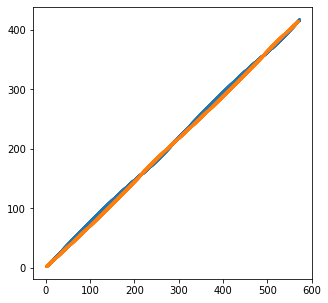

In [ ]:
def E_pot(body1, body2):
    return -G * body1.mass * body2.mass / (body2.vec_r - body1.vec_r).norm()


def E_full(body1, body2):
    return -E_pot(body1, body2) + body1.E_kin() + body2.E_kin()


def test1(k, n):
    random.seed(5)
    body1 = Body(random.random() * 10, vec_r=[random.random() * 5, random.random() * 5],
                 vec_v=[random.random() * 5, random.random() * 5])
    body2 = Body(random.random() * 10, vec_r=[random.random() * 5, random.random() * 5],
                 vec_v=[random.random() * 5, random.random() * 5])
    print(body1)
    print(body2)
    E0 = E_full(body1, body2)
    i = 0
    while math.fabs(E0 - E_full(body1, body2)) < k * E0 and i < n:
        gravitate(Body(0), [body1, body2])
        # assert math.fabs(E0 - E_full(body1, body2)) < 0.1, 'ЗСЭ сломался...'
        i += 1

    if i < n:
        print(f"Ошибка в {k * 100} процент(ов) набежала за {i} итераций")
    else:
        print(f"Ошибка в {k * 100} процент(ов) НЕ набежала за {i} итераций")

    plt.figure(figsize=(5, 5))
    plt.scatter(body1.coordinates[:, 0], body1.coordinates[:, 1], s=1)
    plt.scatter(body2.coordinates[:, 0], body2.coordinates[:, 1], s=1)
    plt.show()


test1(k=0.01, n=50000)

Теперь изобразим звездную систему с двумя планетами и кометой.

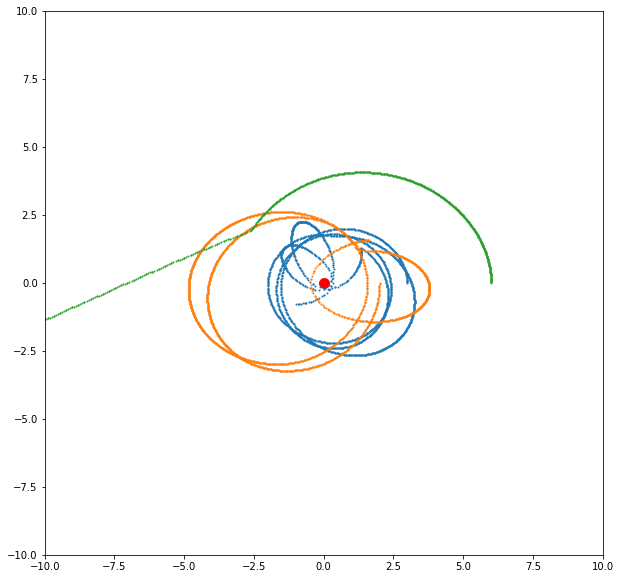

In [ ]:
def plotter(system):
    plt.figure(figsize=(10, 10))
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.scatter(0, 0, s=100, c='r')
    for i in range(len(system)):
        plt.scatter(system[i].coordinates[:, 0], system[i].coordinates[:, 1], s=1)

    plt.show()


Sun = Body(1000)
Earth = Body(50, [3., 0.], [0., 3])
comet = Body(1, [6., 0.], [0., 2])
Venus = Body(80, [2., 0.], [0., -5])

system = [Earth, Venus, comet]
for t in np.arange(0., 5., dt):
    clear_output(wait=True)
    gravitate(Sun, system)
plotter(system)

Смоделируем систему из 4 тел, которые появляются на разных шагах итерации:

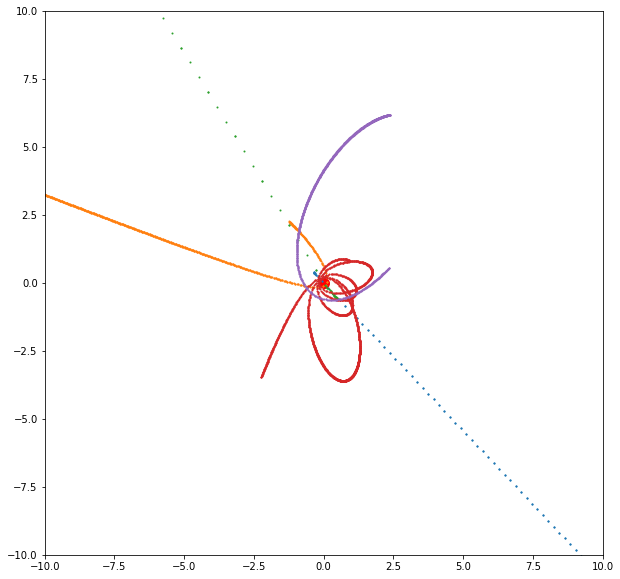

[4.115, 3.265, 0.8, 2.6]


In [ ]:
dt = 0.005
t0 = 5.
Sun = Body(1000)
random.seed(10)
system = [Body((random.random() - 0.5) * 10, vec_r=[(random.random() - 0.5) * 5, (random.random() - 0.5) * 5],
               vec_v=[(random.random() - 0.5) * 5, (random.random() - 0.5) * 5])]
r = [int(random.random() * t0 / dt) * (1 + i - i) * dt for i in range(4)]

for t in np.arange(0., t0, dt):
    if t in r:
        system.append(
            Body((random.random() - 0.5) * 10, vec_r=[(random.random() - 0.5) * 5, (random.random() - 0.5) * 5],
                 vec_v=[(random.random() - 0.5) * 5, (random.random() - 0.5) * 5]))
    clear_output(wait=True)
    gravitate(Sun, system)
plotter(system)
print(r)

# Детектирование орбит
![Вырезка из Механики Сивухина](https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2Fa2187199-ccab-4716-96e4-47ad743390f2%2FUntitled.png?table=block&id=21a00b06-e814-4faa-9670-1d1bf788a2ed&spaceId=9b31c034-a12a-4a00-aa06-94d40481c90f&width=2000&userId=091be9fe-15b8-4388-9b1c-f8c26db2761b&cache=v2)
Условие задачи по детектированию орбит не совсем верно. Космическое тело в поле тяготения звезды может двигаться по орбитам, являющимся коническими сечениями, т.е. по эллипсу (эксцентриситет e < 1), параболе (e = 1) и гиперболе (e > 1) (см. [1, стр. 312]. При этом в двух последних случаях тело покидает сферу влияния звезды. Тип орбиты можно определить по кинетической энергии [1, стр. 316]:
$$E = \dfrac{mv^2}{2} - G\dfrac{mM}{r} = \text{const}\\
\begin{cases}
E > 0, \text{  гипербола}\\
E = 0, \text{  парабола}\\
E < 0, \text{  эллипс}\\
\end{cases}$$

1. Сивухин Д. В. Общий курс физики, т.1. Механика. М.: 1979. 520 с.

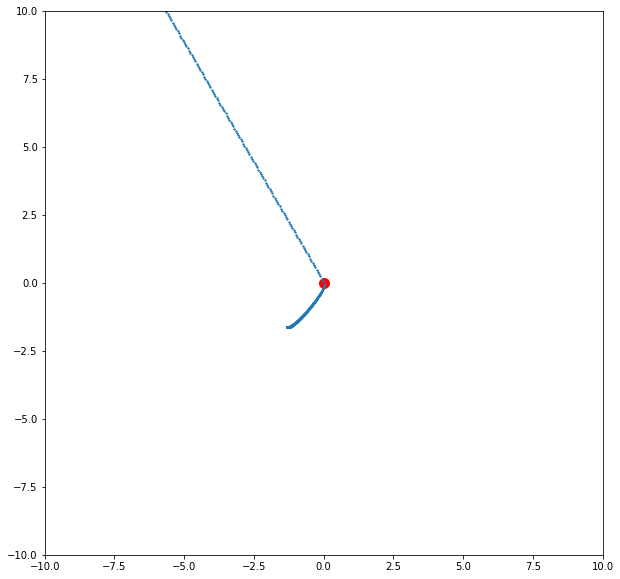

Hyperbolic
None


In [ ]:
def orbit_type(Sun, body):
    E = E_full(Sun, body)
    if E > 0:
        print('Hyperbolic')
    elif E < 0:
        print('Elliptic')
    else:
        print('Parabolic')


dt = 0.001
t0 = 2.
Sun = Body(1000)
random.seed()
system = [Body((random.random() - 0.5) * 10, vec_r=[(random.random() - 0.5) * 5, (random.random() - 0.5) * 5],
               vec_v=[(random.random() - 0.5) * 5, (random.random() - 0.5) * 5])]
print(system[0])

for t in np.arange(0., t0, dt):
    gravitate(Sun, system)
clear_output(wait=True)
plotter(system)
print(orbit_type(Sun, system[0]))

Теперь найдем минимальную скорость, необходимую для того, чтобы тело с заданной массой и координатой вышла на эллиптическую орбиту, т. е. начальное положение было апогелием, а перигелий был равен радиусу звезды:
$$v_{ap} = \sqrt{2GM\dfrac{r_p}{r_a(r_a + r_p)}}$$
Код снизу создает тело в случайной точке и придает ему минмальную скорость (перпендикулярно радиус-вектору), необходимую, чтобы не врезаться в Солнце.

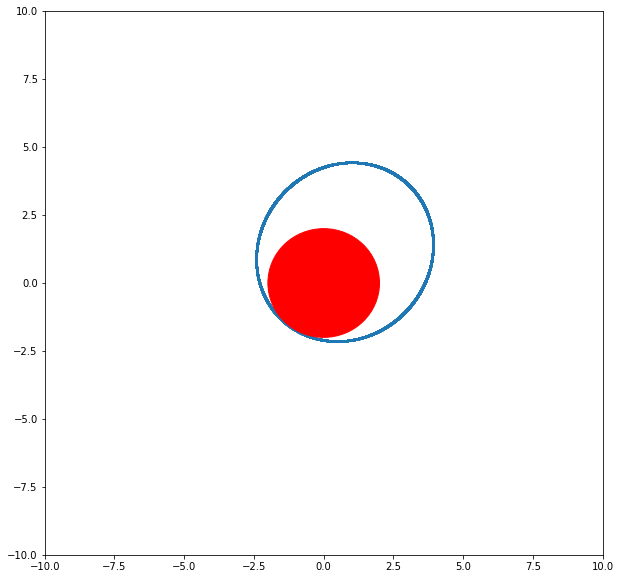

Hyperbolic
None


In [ ]:
R = 2


def opt_velocity(Sun, body):
    e = (body.vec_r.norm() - R) / (body.vec_r.norm() + R)
    return math.sqrt(math.fabs(2 * G * Sun.mass * (1 - e) / (1 + e) / (R + body.vec_r.norm())))


dt = 0.001
t0 = 20
Sun = Body(1000)
random.seed()
comet = Body((random.random() - 0.5) * 10, vec_r=[(random.random() - 0.5), (random.random() - 0.5)],
             vec_v=[0, 0])
comet.vec_r = R * comet.vec_r / comet.vec_r.norm() + 10 * comet.vec_r
comet.vec_v = Vector2D(-comet.vec_r.y, comet.vec_r.x) / comet.vec_r.norm() * opt_velocity(Sun, comet)
print(system[0])

for t in np.arange(0., t0, dt):
    gravitate(Sun, [comet])

clear_output(wait=True)
plt.figure(figsize=(10, 10))
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.scatter(0, 0, s=100, c='r')
circle = plt.Circle((0, 0), R, color='r')
plt.gca().add_patch(circle)
plt.scatter(comet.coordinates[:, 0], comet.coordinates[:, 1], s=1)
plt.show()
print(orbit_type(Sun, system[0]))

Обобщим код на трехмерный случай.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
class Vector3D:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def norm(self):
        return math.sqrt(self.x ** 2 + self.y ** 2 + self.z ** 2)

    def __round__(self, k):
        return Vector3D(round(self.x, k), round(self.y, k), round(self.z, k))

    def __str__(self):
        return '{' + str(self.x) + ', ' + str(self.y) + ', ' + str(self.z) + '} '

    def __lt__(self, other):
        return True if self.norm() < other.norm() else False

    def __le__(self, other):
        return True if self.norm() <= other.norm() else False

    def __eq__(self, other):
        return True if self.x == other.x and self.y == other.y and self.z == other.z else False

    def __ne__(self, other):
        return False if self.x == other.x and self.y == other.y and self.z == other.z else True

    def __gt__(self, other):
        return True if self.norm() > other.norm() else False

    def __ge__(self, other):
        return True if self.norm() >= other.norm() else False

    def __add__(self, other):
        return Vector3D(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vector3D(self.x - other.x, self.y - other.y, self.z - other.z)

    def __mul__(self, other):
        return Vector3D(self.x * other, self.y * other, self.z * other)

    def __truediv__(self, other):
        return Vector3D(self.x / other, self.y / other, self.z / other)

    def __rmul__(self, other):
        return Vector3D(self.x * other, self.y * other, self.z * other)

    def numpy(self):
        return np.array([self.x, self.y, self.z])

In [ ]:
def acceleration(m, r):
    return G * m * r / r.norm() ** 3


class Body:
    def __init__(self, mass, vec_r=[0, 0, 0], vec_v=[0, 0, 0]):
        self.mass = mass
        self.vec_r = Vector3D(vec_r[0], vec_r[1], vec_r[2])
        self.vec_v = Vector3D(vec_v[0], vec_v[1], vec_v[2])
        self.coordinates = np.array(self.vec_r.numpy())

    def __str__(self):
        return f"Mass: {round(self.mass, 2)}; Coordinates: {round(self.vec_r, 2)}; Velocity: {round(self.vec_v, 2)}"

    def E_kin(self):
        return self.mass * self.vec_v.norm() ** 2 / 2


# def gravitate(Sun, bodies: list):
#     for i in range(len(bodies)):
#         dv = acceleration(Sun.mass, Sun.vec_r - bodies[i].vec_r) * dt
#         bodies[i].vec_v += dv
#         bodies[i].vec_r += bodies[i].vec_v * dt
#         bodies[i].coordinates = np.vstack([bodies[i].coordinates, bodies[i].vec_r.numpy()])
#         bodies[i].coordinates = np.vstack([bodies[i].coordinates, bodies[i].vec_r.numpy()])
#         for j in [j for j in range(len(bodies)) if j != i]:
#             dv = acceleration(bodies[i].mass, bodies[i].vec_r - bodies[j].vec_r) * dt
#             bodies[j].vec_v += dv
#             bodies[j].vec_r += bodies[j].vec_v * dt
#             bodies[j].coordinates = np.vstack([bodies[j].coordinates, bodies[j].vec_r.numpy()])
#     # print(self.coordinates)

Mass: 6.23; Coordinates: {3.71, 3.98, 4.71} ; Velocity: {3.7, 4.61, 0.15} 
Mass: 4.66; Coordinates: {4.72, 3.24, 4.5} ; Velocity: {0.57, 2.35, 1.23} 
Ошибка в 1.0 процент(ов) набежала за 260 итераций


/var/folders/3g/g_x_zpf96vj03l90sdwxj92m0000gn/T/ipykernel_25904/997495454.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


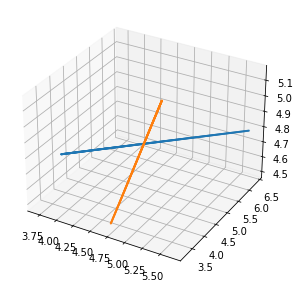

In [ ]:
# def E_pot(body1, body2):
#     return -G * body1.mass * body2.mass / (body2.vec_r - body1.vec_r).norm()
#
#
# def E_full(body1, body2):
#     return -E_pot(body1, body2) + body1.E_kin() + body2.E_kin()

def test1(k, n):
    random.seed(5)
    body1 = Body(random.random() * 10, vec_r=[random.random() * 5, random.random() * 5, random.random() * 5],
                 vec_v=[random.random() * 5, random.random() * 5, random.random() * 5])
    body2 = Body(random.random() * 10, vec_r=[random.random() * 5, random.random() * 5, random.random() * 5],
                 vec_v=[random.random() * 5, random.random() * 5, random.random() * 5])
    print(body1)
    print(body2)
    E0 = E_full(body1, body2)
    i = 0
    while math.fabs(E0 - E_full(body1, body2)) < k * E0 and i < n:
        gravitate(Body(0), [body1, body2])
        # assert math.fabs(E0 - E_full(body1, body2)) < 0.1, 'ЗСЭ сломался...'
        i += 1

    if i < n:
        print(f"Ошибка в {k * 100} процент(ов) набежала за {i} итераций")
    else:
        print(f"Ошибка в {k * 100} процент(ов) НЕ набежала за {i} итераций")

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(body1.coordinates[:, 0], body1.coordinates[:, 1], body1.coordinates[:, 2],  s=1)
    ax.scatter(body2.coordinates[:, 0], body2.coordinates[:, 1], body2.coordinates[:, 2], s=1)
    fig.show()


test1(k=0.01, n=50000)

/var/folders/3g/g_x_zpf96vj03l90sdwxj92m0000gn/T/ipykernel_25904/3281170971.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


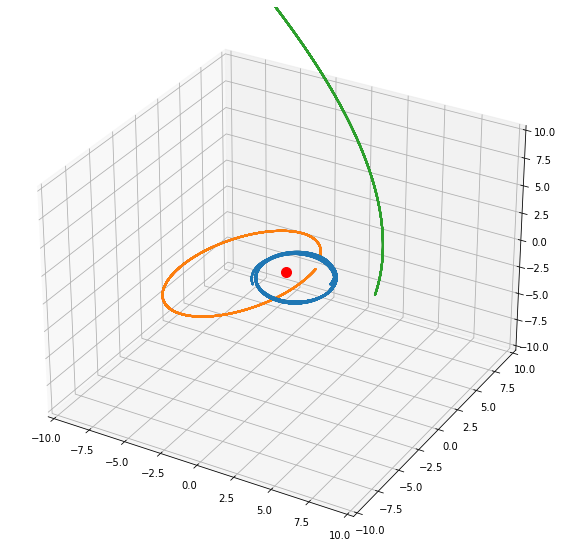

In [ ]:
def plotter(system):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.axes.set_xlim3d(-10, 10)
    ax.axes.set_ylim3d(-10, 10)
    ax.axes.set_zlim3d(-10, 10)
    ax.scatter(0, 0, 0, s=100, c='r')
    for i in range(len(system)):
        ax.scatter(system[i].coordinates[:, 0], system[i].coordinates[:, 1],system[i].coordinates[:, 2], s=1)
    fig.show()


Sun = Body(1000)
Earth = Body(50, [3., 0., 0], [0., 3, 0.4])
comet = Body(1, [6., 0., 0.2], [0., 2, 3])
Venus = Body(80, [2., 0., 1], [0., -5, -1])

system = [Earth, Venus, comet]
for t in np.arange(0., 5., dt):
    clear_output(wait=True)
    gravitate(Sun, system)
plotter(system)

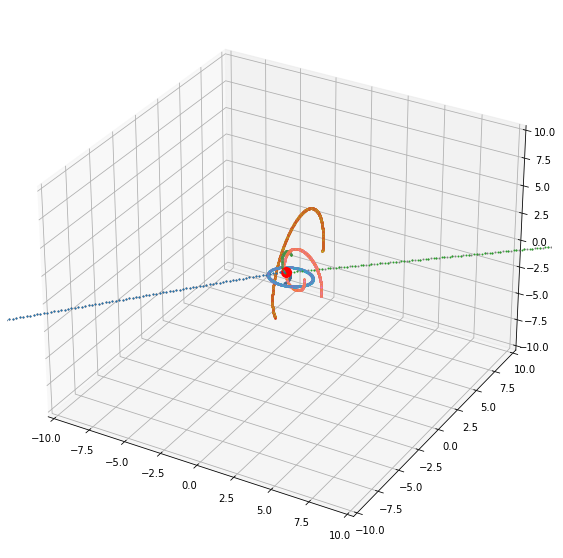

In [ ]:
dt = 0.005
t0 = 5.
Sun = Body(1000)
random.seed(10)

def plotter(system):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.axes.set_xlim3d(-10, 10)
    ax.axes.set_ylim3d(-10, 10)
    ax.axes.set_zlim3d(-10, 10)
    ax.scatter(0, 0, 0, s=100, c='r')
    for i in range(len(system)):
        ax.scatter(system[i].coordinates[:, 0], system[i].coordinates[:, 1],system[i].coordinates[:, 2], s=1)
    fig.show()

system = [Body((random.random() - 0.5) * 10, vec_r=[(random.random() - 0.5) * 5, (random.random() - 0.5) * 5, (random.random() - 0.5) * 5],
               vec_v=[(random.random() - 0.5) * 5, (random.random() - 0.5) * 5, (random.random() - 0.5) * 5])]
r = [int(random.random() * t0 / dt) * (1 + i - i) * dt for i in range(4)]

for t in np.arange(0., t0, dt):
    if t in r:
        system.append(
            Body((random.random() - 0.5) * 10, vec_r=[(random.random() - 0.5) * 5, (random.random() - 0.5) * 5, (random.random() - 0.5) * 5],
                 vec_v=[(random.random() - 0.5) * 5, (random.random() - 0.5) * 5, (random.random() - 0.5) * 5]))
    gravitate(Sun, system)
clear_output(wait=True)
plotter(system)
print(r)

In [ ]:
import matplotlib.pyplot as plt

for angle in range(70, 210, 2):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.axes.set_xlim3d(-10, 10)
    ax.axes.set_ylim3d(-10, 10)
    ax.axes.set_zlim3d(-10, 10)
    ax.scatter(0, 0, 0, s=100, c='r')
    for i in range(len(system)):
        ax.scatter(system[i].coordinates[:, 0], system[i].coordinates[:, 1],system[i].coordinates[:, 2], s=1)

    ax.view_init(30, angle)

    filename = str(angle)+'.png'
    plt.savefig(filename, dpi=96)
    plt.gca()

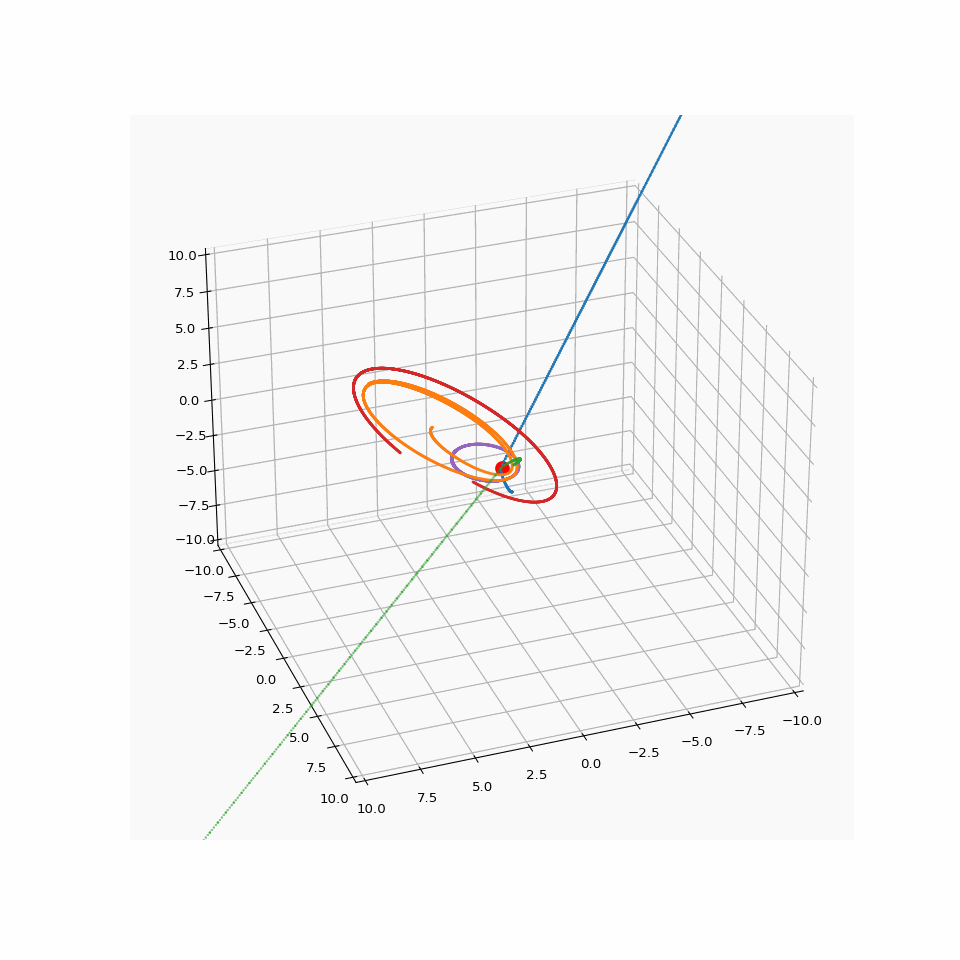

In [ ]:
from PIL import Image
frames = []
for frame_number in range(70, 210, 2):
    frame = Image.open(f'{frame_number}.png')
    frames.append(frame)

frames[0].save(
    'star.gif',
    save_all=True,
    append_images=frames[1:],  # Срез который игнорирует первый кадр.
    optimize=True,
    duration=[200]*len(frames),
    loop=0
)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path
gifPath = Path("star.gif")
with open(gifPath,'rb') as f:
    display.Image(data=f.read(), format='png')